# Comparison between SCUBA and SCUBA-2 Cores

This document will serve to compare the Field pointing information for the OrionBN dataset, which is built upon the SCUBA dataset for contended starless cores. However, much newer information is present in the SCUBA-2 Dataset for this region, given by Kirk+2016.

Additionally, the SCUBA(-1) dataset will build the basis for the statistics regarding expected detections from the ALMA dataset. Furthermore, since there is a exact mapping between the SCUBA-2 cores from Kirk+2016 to those SCUBA(-1) cores in Nutter+2007 (specifically by the method used to match the cores to one another, see Kirk+2016 for explanation), we can use the SCUBA-2 cores in addition to the SCUBA(-1) cores as comparisons to make, while analysis is ongoing.

# Part 1 - Imports and IO

In [1]:
import pathlib
from astropy.table import QTable
from astropy.coordinates import SkyCoord
import pandas as pd
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.wcs import WCS
import numpy as np

In [2]:
%matplotlib inline


This will load the data into the Catalog Class instances.

In [3]:
RA_STRINGS = ['_RAJ20001', '_RAJ2000', 'RAJ2000', 'RA_Deg', 'ra']
DEC_STRINGS = ['_DEJ20001', '_DEJ2000', 'DEJ2000', 'DEC_Deg', 'dec']
FIELDNAME_STRINGS = ['HOPS', 'Name2', 'Name', 'Name1', 'MJLSG', 'FieldA1', 'Seq', '__NW2007_', 'Source Name', 'SESNA_NAME']

class Catalog:
    def __init__(self,
                 inputpath: pathlib.Path,
                 catalogname: str) -> None:
        
        # load the catalog into QTable
        self.table = QTable.read(inputpath, format='fits', character_as_bytes=False)
        
        # transfer the catalog into DataFrame
        self.frame = self.table.to_pandas()
        
        # set the name of the catalog
        self.name = catalogname
        
        # pull column names for dataframe
        self.ra_col_name = self.frame.columns.intersection(RA_STRINGS)[0]
        self.dec_col_name = self.frame.columns.intersection(DEC_STRINGS)[0]
        self.name_col_name = self.frame.columns.intersection(FIELDNAME_STRINGS)[0]
        
        # generate quantity arrays for ra and dec values in catalog
        self.q_ra = self.frame[self.ra_col_name].values * u.deg
        self.q_dec = self.frame[self.dec_col_name].values * u.deg
        
        # generate skycoord(s)
        self.sc = SkyCoord(self.q_ra, self.q_dec, frame='icrs')
                
    def __str__(self) -> str:
        return f'Catalog Name : {self.name} --- Total Objects: {len(self.sc)}'
    
    def matchsources(self, catalog):
        
        # gather the source names for main catalog
        names = self.frame[self.name_col_name].values
        
        # create DataFrame for associations if not yet found
        if hasattr(self, 'associations'):
            pass
        else:
            self.associations = pd.DataFrame({'Source Name' : names}, index=range(len(names)))

        # gather the source names for the given catalog
        namecol2 = catalog.frame.columns.intersection(FIELDNAME_STRINGS)[0]
        names2 = catalog.frame[namecol2].values
        
        # perform catalog matching
        idx, d2d, d3d = self.sc.match_to_catalog_sky(catalog.sc)
        
        sep_amt_arcsec = d2d.arcsec
        sep_name = names2[idx]
        
        self.associations[f'{catalog.name} Source Name'] = sep_name
        self.associations[f'{catalog.name} Source Separation'] = sep_amt_arcsec
        
        return

## The Full Nutter Catalog will be loaded into `df_nwt`
## The Full SCUBA2 Catalog will be loaded into `df_scuba2`

In [4]:
path_scuba = pathlib.Path('/Users/samuelfielder/Documents/analysis/catalogues/final/Scuba-Nutter2007.fit')
c1 = Catalog(path_scuba, 'SCUBA1')
# convert to dataframe
df_nwt = c1.frame

# rename columns - mass
df_nwt.rename(columns={'Mass': 'Mass_msol'}, inplace=True)

path_scuba2 = pathlib.Path('/Users/samuelfielder/Documents/analysis/catalogues/final/Scuba2-Kirk2016.fit')
c2 = Catalog(path_scuba2, 'SCUBA2')
# convert to dataframe
df_scuba2 = c2.frame

# rename column - radius
df_scuba2.rename(columns={'Reff': 'Reff_pc'}, inplace=True)

# Part 2 - Computing Concentration and Number Density for SCUBA-2 Cores

The mass for SCUBA-2 cores comes directly from Kirk+2016 (although not given in data):

$$
M = \frac{s_{\nu}D^2}{\kappa_{\nu} B_{\nu}(T)} \\
M = 1.06 \times S_{850 \mu m} \times (e^{\frac{17 \ K}{T}}-1) \times (\kappa_{850 \mu m}/0.0125 \ \text{cm}^2 \ \text{g}^{-1})^{-1} \times (D/415 \ \text{pc})^2
$$

Additionally, the core concentration also comes directly from Kirk+2016 (although not given in data):

$$
C = 1 - \frac{1.13 B^2 F_{\text{tot}}}{\pi R^2 F_{\text{pk}}}
$$

The specific beamwidth for the SCUBA-2 dataset is 14.6 arcsec.

Finally, the number density can be computed from the following:

$$
n = \frac{3}{4\pi \mu m_H} \frac{M}{R_{\text{eff}}^3}
$$

In [5]:
def linear_to_angular(length, distance):
    """Returns angular length in arcsec. `length` and `distance` must have matching units."""
    return (length/distance) * 206265

def angular_to_linear(angle, distance):
    """Returns linear length in matching distance units. `angle` must be in arcsec."""
    return (angle/206265) * distance

In [6]:
def scuba2mass(total_flux, distance, kappa, temperature):
    """Computes SCUBA-2 core mass, according to eq given in Kirk+2016. Returns units of Msol.

    Parameters
    ----------
    total_flux : Integrated Flux (Jy)
    distance : (pc)
    kappa : (cm^2 g^-1)
    temperature : (K)
    """
    return 1.06 * total_flux * np.expm1(17/temperature) * ((distance/415)**2) / (kappa/0.0125)

def scuba2concentration(beamsize_arcsec, total_flux_jy, radius_arcsec, peak_flux_jyperbeam):
    """Computes SCUBA-2 core concentration, according to eq given in Kirk+2016

    Parameters
    ----------
    beamsize_arcsec : Effective Beam Width (arcsec)
    total_flux_jy : Integrated Flux (Jy)
    radius_arcsec : Effective Radius (arcsec)
    peak_flux_jyperbeam : Peak Flux (Jy/beam)
    """
    num = 1.13 * (beamsize_arcsec**2) * total_flux_jy
    denom = np.pi * (radius_arcsec**2) * peak_flux_jyperbeam
    frac = num/denom
    return 1-frac

def numberdensity(mass_msol, radius_arcsec):
    """Computes number density assuming mu = 2.37. Returns of units per cm^-3.

    Parameters
    ----------
    mass_msol : Integrated Mass (Solar Mass)
    radius_arcsec : Effective Radius (arcsec)
    """
    MU = 2.37
    MH = 1.6725575e-24 # units are grams
    m = mass_msol * 1.989e+33 # msol to cm conversion
    r = angular_to_linear(radius_arcsec, 415) * 3.086e+18 # pc to cm conversion
    # split the division to avoid overflow
    numer = 3 * m / r
    denom = 4 * np.pi * MU * MH * (r**2)
    return numer / denom

In [7]:
# compute angular radius
reff_arcsec = linear_to_angular(df_scuba2['Reff_pc'], 415)
df_scuba2['Reff_arcsec'] = reff_arcsec

# compute core mass
mass_msol = scuba2mass(df_scuba2['F850Tot'], 415, 0.0125, 20)
df_scuba2['Mass_msol'] = mass_msol

# compute concentration
# uses 14.6 arcsec beam width
concentrations = [scuba2concentration(beam, tf, radius, peak) for beam, tf, radius, peak in zip([14.6]*len(df_scuba2['F850Tot']),
                                                                                                df_scuba2['F850Tot'],
                                                                                                df_scuba2['Reff_arcsec'],
                                                                                                df_scuba2['F850Pk'])]
df_scuba2['Concentration'] = concentrations

# compute number density
number_density = numberdensity(df_scuba2['Mass_msol'].values, df_scuba2['Reff_arcsec'].values)
df_scuba2['Number_density'] = number_density

## Compare to Kirk+2016 Figure 10 - Using as double check that work is correct up until this point

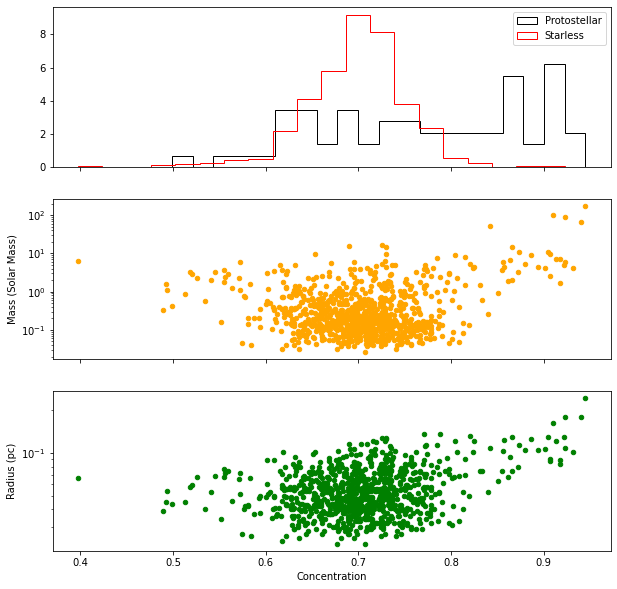

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,10), sharex=True)
# histogram
ax1.hist(df_scuba2[df_scuba2['YSO'] == 'Y']['Concentration'], bins=20, density=True, histtype='step', label='Protostellar', color='k')
ax1.hist(df_scuba2[df_scuba2['YSO'] == 'N']['Concentration'], bins=20, density=True, histtype='step', label='Starless', color='r')
#ax1.set_ylabel('Fraction')
# scatter middle
ax2.scatter(df_scuba2['Concentration'], df_scuba2['Mass_msol'], c='orange', s=20)
ax2.set_yscale('log')
ax2.set_ylabel('Mass (Solar Mass)')
# scatter bottom
ax3.scatter(df_scuba2['Concentration'], df_scuba2['Reff_pc'], c='green', s=20)
ax3.set_yscale('log')
ax3.set_ylabel('Radius (pc)')
ax1.legend()
ax3.set_xlabel('Concentration')
plt.show()

Comparison to Kirk+2016 Figure 10 is a match.

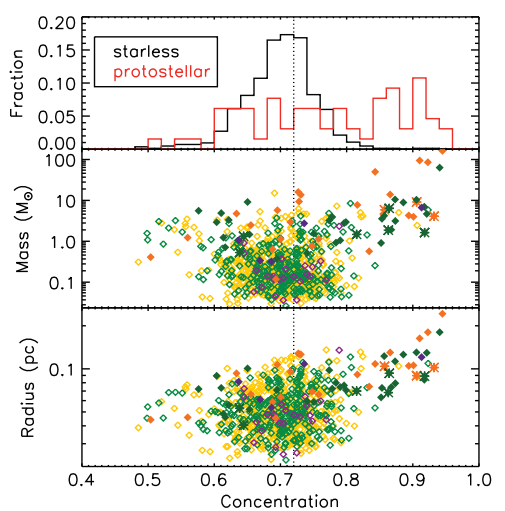

# Part 3 - Computing Concentration and Number Density for SCUBA(-1) Cores

In [9]:
# compute radius linear (from amaj and bmaj)
reff_arcsec = np.sqrt(df_nwt['amaj'] * df_nwt['bmaj'])
df_nwt['Reff_arcsec'] = reff_arcsec

# compute radius linear in pc
reff_pc = angular_to_linear(df_nwt['Reff_arcsec'], 419)
df_nwt['Reff_pc'] = reff_pc

# compute concentration
concentrations = [scuba2concentration(beam, tf, radius, peak) for beam, tf, radius, peak in zip([14.0]*len(df_nwt['I850']),
                                                                                                df_nwt['I850'],
                                                                                                df_nwt['Reff_arcsec'],
                                                                                                df_nwt['P850'])]
df_nwt['Concentration'] = concentrations

# compute number density
number_density = numberdensity(df_nwt['Mass_msol'].values, df_nwt['Reff_arcsec'].values)
df_nwt['Number_density'] = number_density

# Part 4 - Inspecting SCUBA(-1) Cores

## Core Elongation - SCUBA1-Cores

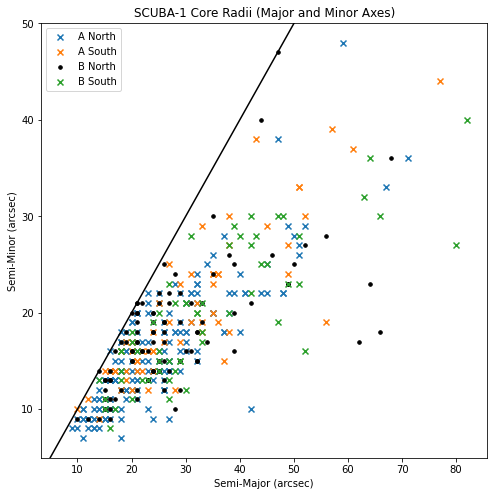

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(df_nwt[df_nwt['__NW2007_'].str.contains('AN')]['amaj'],
            df_nwt[df_nwt['__NW2007_'].str.contains('AN')]['bmaj'],
            label='A North',
            marker='x')
plt.scatter(df_nwt[df_nwt['__NW2007_'].str.contains('AS')]['amaj'],
            df_nwt[df_nwt['__NW2007_'].str.contains('AS')]['bmaj'],
            label='A South',
            marker='x')
plt.scatter(df_nwt[df_nwt['__NW2007_'].str.contains('BN')]['amaj'],
            df_nwt[df_nwt['__NW2007_'].str.contains('BN')]['bmaj'],
            label='B North',
            marker='.',
            s=50,
            c='k')
plt.scatter(df_nwt[df_nwt['__NW2007_'].str.contains('BS')]['amaj'],
            df_nwt[df_nwt['__NW2007_'].str.contains('BS')]['bmaj'],
            label='B South',
            marker='x')
plt.xlabel('Semi-Major (arcsec)')
plt.ylabel('Semi-Minor (arcsec)')
plt.title('SCUBA-1 Core Radii (Major and Minor Axes)')
plt.legend()
plt.axline((7,7), (10,10), color='k')
plt.show()

### Core Radii Distribution - SCUBA1 Cores

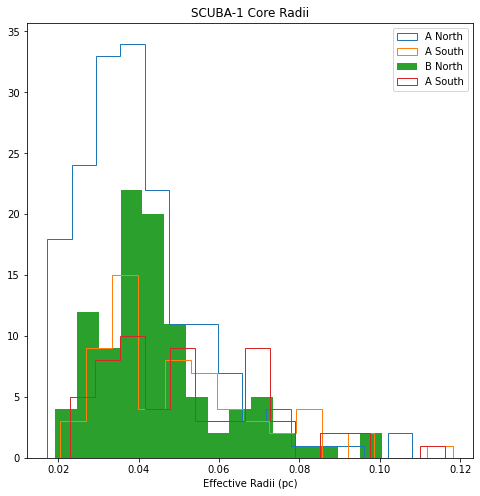

In [11]:
plt.figure(figsize=(8,8))
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AN')]['Reff_pc'], bins=15, histtype='step', label='A North')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AS')]['Reff_pc'], bins=15, histtype='step', label='A South')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('BN')]['Reff_pc'], bins=15, histtype='bar', label='B North')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('BS')]['Reff_pc'], bins=15, histtype='step', label='A South')
plt.title('SCUBA-1 Core Radii')
plt.legend()
plt.xlabel('Effective Radii (pc)')
plt.show()

### Core Mass Distribution - SCUBA1 Cores

/var/folders/rr/qr_hcjz13v1cdgh7nf3t6gjc0000gn/T/ipykernel_50676/3439397762.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AN')][df_nwt['Mass_msol'] < 20]['Mass_msol'], bins=15, histtype='step', density=True, label='A North')
/var/folders/rr/qr_hcjz13v1cdgh7nf3t6gjc0000gn/T/ipykernel_50676/3439397762.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AS')][df_nwt['Mass_msol'] < 20]['Mass_msol'], bins=15, histtype='step', density=True, label='A South')
/var/folders/rr/qr_hcjz13v1cdgh7nf3t6gjc0000gn/T/ipykernel_50676/3439397762.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('BN')][df_nwt['Mass_msol'] < 20]['Mass_msol'], bins=15, histtype='bar', density=True, label='B North')
/var/folders/rr/qr_hcjz13v1cdgh7nf3t6gjc0000gn/T/ipykernel_506

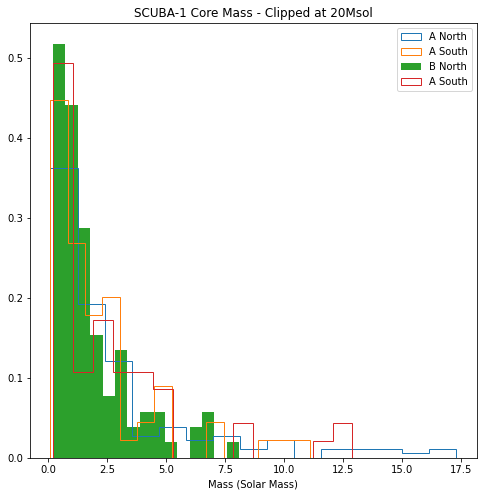

In [12]:
plt.figure(figsize=(8,8))
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AN')][df_nwt['Mass_msol'] < 20]['Mass_msol'], bins=15, histtype='step', density=True, label='A North')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AS')][df_nwt['Mass_msol'] < 20]['Mass_msol'], bins=15, histtype='step', density=True, label='A South')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('BN')][df_nwt['Mass_msol'] < 20]['Mass_msol'], bins=15, histtype='bar', density=True, label='B North')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('BS')][df_nwt['Mass_msol'] < 20]['Mass_msol'], bins=15, histtype='step', density=True, label='A South')
plt.title('SCUBA-1 Core Mass - Clipped at 20Msol')
plt.xlabel('Mass (Solar Mass)')
plt.legend()
plt.show()

### There are cores that lie above the threshold given here. These are notably the following for reference:

In [13]:
df_nwt[df_nwt['Mass_msol'] > 20]

,_RAJ2000,_DEJ2000,__NW2007_,RAJ2000,DEJ2000,amaj,bmaj,P850,I850,P450,I450,Mass_msol,YSO,Simbad,Reff_arcsec,Reff_pc,Concentration,Number_density
37,83.810833,-5.439722,AN-535146-52623,83.810833,-5.439722,71.0,36.0,2.400000,34.299999,9.600000,89.400002,53.900002,Y,Simbad,50.556899,0.102700,0.605809,2.087415e+05
39,83.842500,-5.419444,AN-535222-52510,83.842500,-5.419444,35.0,26.0,2.500000,16.100000,7.800000,48.700001,44.000000,N,Simbad,30.166206,0.061279,0.501082,8.021433e+05
41,83.855833,-5.409167,AN-535254-52433,83.855833,-5.409167,29.0,22.0,3.800000,13.900000,11.100000,41.200001,50.700001,N,Simbad,25.258662,0.051310,0.595801,1.574484e+06
43,83.806667,-5.402500,AN-535136-52409,83.806667,-5.402500,47.0,38.0,46.299999,213.500000,137.500000,629.000000,392.899994,Y,Simbad,42.261093,0.085848,0.817980,2.605081e+06
51,83.810000,-5.375833,AN-535144-52233,83.810000,-5.375833,59.0,48.0,143.500000,517.799988,279.200012,1263.800049,991.400024,N,Simbad,53.216539,0.108102,0.910174,3.292080e+06
58,83.825417,-5.358056,AN-535181-52129,83.825417,-5.358056,26.0,14.0,5.400000,12.700000,17.299999,39.799999,36.400002,N,Simbad,19.078784,0.038756,0.544495,2.623075e+06
60,83.817083,-5.353056,AN-535161-52111,83.817083,-5.353056,19.0,16.0,6.000000,15.600000,23.700001,63.200001,42.599998,Y,Simbad,17.435596,0.035418,0.397046,4.022171e+06
62,83.826667,-5.346944,AN-535184-52049,83.826667,-5.346944,23.0,15.0,4.000000,9.100000,13.800000,31.799999,26.400000,Y,Simbad,18.574176,0.037731,0.535113,2.061753e+06
66,83.817917,-5.345278,AN-535163-52043,83.817917,-5.345278,23.0,22.0,7.600000,24.799999,30.799999,93.199997,62.099998,N,Simbad,22.494444,0.045694,0.545355,2.730405e+06
75,83.820833,-5.323333,AN-535170-51924,83.820833,-5.323333,49.0,29.0,7.500000,40.599998,30.799999,163.399994,86.699997,Y,Simbad,37.696154,0.076575,0.731431,8.100080e+05


### Core Concentration - SCUBA1 Cores

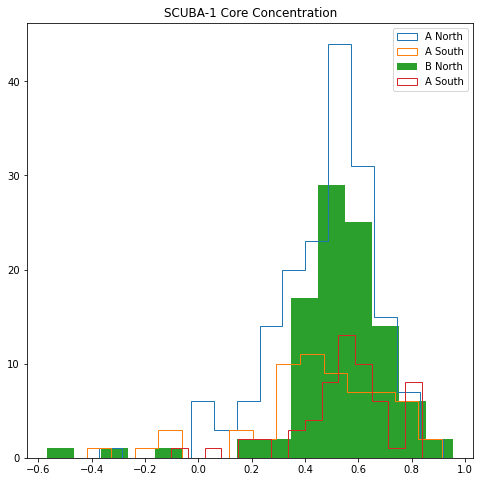

In [14]:
plt.figure(figsize=(8,8))
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AN')]['Concentration'], bins=15, histtype='step', label='A North')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('AS')]['Concentration'], bins=15, histtype='step', label='A South')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('BN')]['Concentration'], bins=15, histtype='bar', label='B North')
plt.hist(df_nwt[df_nwt['__NW2007_'].str.contains('BS')]['Concentration'], bins=15, histtype='step', label='A South')
plt.title('SCUBA-1 Core Concentration')
plt.legend()
plt.show()

There are notably negative concentration values (total of 17 cores) This shouldn't be possible with observation.

For example: Core BN-547080+02505 (the most negative core)

* Integrated Flux: 0.2 Jy
* Peak Flux: 0.1 Jy/beam
* Beamwidth: 14.6 arcsec
* Radius: 9.4868 arcsec

Computation:
B^2 / R^2 = (14.6/9.4868)^2 = 2.368
Ftot / Fpk = 2.0

C = 1 - (1.13 * 2.368 * 2.0 / pi) = -0.703

- Most likely due to rounding and smaller beamsize used at 14 arcsec (versus the 14.6 arcsec).

### The computation of the SCUBA-1 values, use the exact same function as the SCUBA-2 cores, which reproduce the correct results, as shown above.

# Part 5 - Computing Associations

Matching will be done using the segmentation map from the FellWalker algorithm. This is guided by Kirk_2016, in which this technique was used to match all SCUBA(-1) cores to a SCUBA-2 core. It is not a 1-to-1 match, but it is very close.

In [15]:
# create new dataframe with just B-North Data
df_nwt_trimmed = df_nwt[df_nwt['__NW2007_'].str.contains('BN')]

# create the skycoordinates for matching
sc_bn = SkyCoord(df_nwt_trimmed['_RAJ2000'].values * u.deg, df_nwt_trimmed['_DEJ2000'].values * u.deg, frame='icrs')

In [16]:
# load in the segmentation map from Kirk+2016
seg_data = fits.getdata('OrionB_N2068_20150914_850_LR1_FellWalker_HK.fits')
seg_header = fits.getheader('OrionB_N2068_20150914_850_LR1_FellWalker_HK.fits')

# generate WCS class to switch between pixel and world value
wcs = WCS(seg_header, naxis=2) # only the ra and dec information, so slice with naxis

# convert SkyCoords of c1 to pixels in the c2 reference frame
c1_pixels = wcs.world_to_pixel(sc_bn)
c1_pixels_x = c1_pixels[0].astype(int)
c1_pixels_y = c1_pixels[1].astype(int)

# find the SCUBA-2 Core reference values for each SCUBA(-1) core
c1_pixelval = [int(seg_data[x,y]) for x,y in zip(c1_pixels_y, c1_pixels_x)] # no idea why I have to pass it in backwards...

Set OBSGEO-B to    19.822855 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [17]:
# trim the c2 to only be in the N2068/2071 area
d2_trim = df_scuba2[df_scuba2['Region'] == 'N2068/2071']

In [18]:
# grabbing all relevant information and building association dataframe
match_scuba2core = []
match_yso = []
match_cat = []
match_mass = []
match_radius_pc = []
match_radius_arcsec = []
match_concentration = []
match_number_density = []
row_data = []

# loop through all scuba2 core identifiers
for s in c1_pixelval:
    # grab the row
    row = d2_trim.loc[d2_trim['Seq'] == s]
    
    # grab the matched scuba2 core information
    match_scuba2core.append(row['MJLSG'].values[0])
    match_yso.append(row['YSO'].values[0])
    match_cat.append(row['YSOCat'].values[0])
    match_mass.append(row['Mass_msol'].values[0])
    match_radius_pc.append(row['Reff_pc'].values[0])
    match_radius_arcsec.append(row['Reff_arcsec'].values[0])
    match_concentration.append(row['Concentration'].values[0])
    match_number_density.append(row['Number_density'].values[0])
    row_data.append(row)

# add to dataframe
df_nwt_trimmed['SCUBA2 Core Name'] = match_scuba2core
df_nwt_trimmed['SCUBA2 YSO Flag'] = match_yso
df_nwt_trimmed['SCUBA2 YSO Cat'] = match_cat
df_nwt_trimmed['SCUBA2 Mass_msol'] = match_mass
df_nwt_trimmed['SCUBA2 Reff_pc'] = match_radius_pc
df_nwt_trimmed['SCUBA2 Reff_arcsec'] = match_radius_arcsec
df_nwt_trimmed['SCUBA2 Concentration'] = match_concentration
df_nwt_trimmed['SCUBA2 Number_density'] = match_number_density

/var/folders/rr/qr_hcjz13v1cdgh7nf3t6gjc0000gn/T/ipykernel_50676/1308399179.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nwt_trimmed['SCUBA2 Core Name'] = match_scuba2core
/var/folders/rr/qr_hcjz13v1cdgh7nf3t6gjc0000gn/T/ipykernel_50676/1308399179.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nwt_trimmed['SCUBA2 YSO Flag'] = match_yso
/var/folders/rr/qr_hcjz13v1cdgh7nf3t6gjc0000gn/T/ipykernel_50676/1308399179.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

# Part 6 - Comparing Matched SCUBA(-1) and SCUBA-2 Cores

## Unless stated otherwise, all plots below this point that are marked SCUBA-1, will be the 100 cores in the B-North (pre-stellar and protostellar)

### Core Mass Distribution - B-North SCUBA1 and SCUBA2

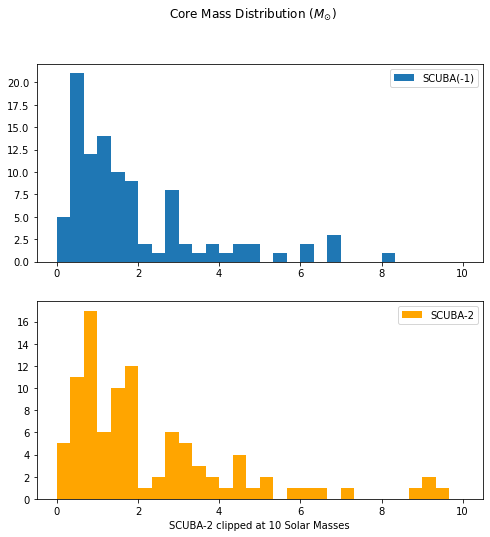

In [19]:
bins=30
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.hist(df_nwt_trimmed['Mass_msol'], bins=bins, range=(0,10), label='SCUBA(-1)')
ax2.hist(df_nwt_trimmed['SCUBA2 Mass_msol'], bins=bins, range=(0,10), label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
fig.suptitle(r'Core Mass Distribution ($M_{\odot}$)')
ax2.set_xlabel('SCUBA-2 clipped at 10 Solar Masses')
plt.show()

### Effective Radius Distribution - B-North SCUBA1 and SCUBA2

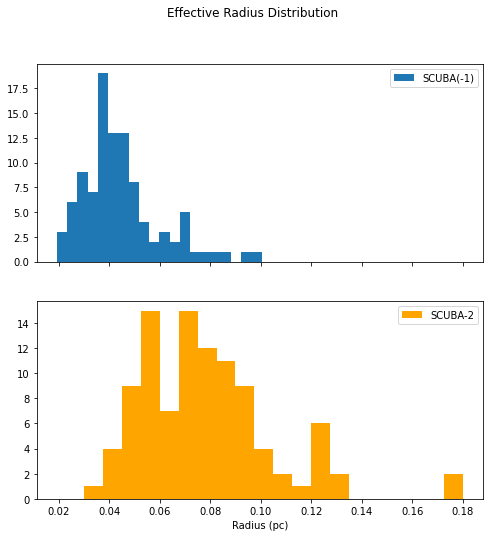

In [20]:
bins=20
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)
ax1.hist(df_nwt_trimmed['Reff_pc'], bins=bins, label='SCUBA(-1)')
ax2.hist(df_nwt_trimmed['SCUBA2 Reff_pc'], bins=bins, label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
fig.suptitle(r'Effective Radius Distribution')
ax2.set_xlabel('Radius (pc)')
plt.show()

### Concentration Distribution - B-North SCUBA1 and SCUBA2

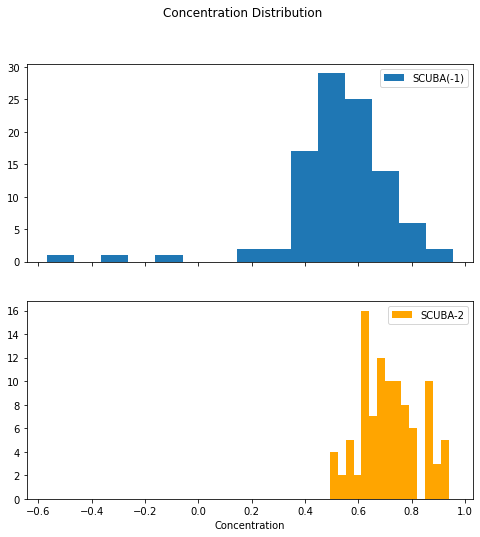

In [21]:
bins=15
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)
ax1.hist(df_nwt_trimmed['Concentration'], bins=bins, label='SCUBA(-1)')
ax2.hist(df_nwt_trimmed['SCUBA2 Concentration'], bins=bins, label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
ax2.set_xlabel('Concentration')
fig.suptitle('Concentration Distribution')
plt.show()

### Core Mass versus Radius - B-North SCUBA1 and SCUBA2

One data point lies at high mass above the range of the plot.

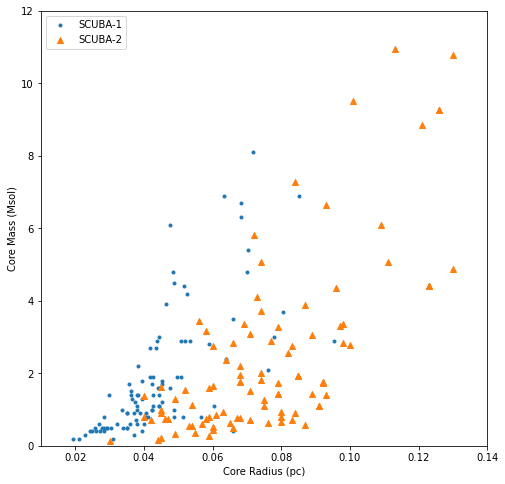

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(df_nwt_trimmed['Reff_pc'], df_nwt_trimmed['Mass_msol'], marker='.', label='SCUBA-1')
plt.scatter(df_nwt_trimmed['SCUBA2 Reff_pc'], df_nwt_trimmed['SCUBA2 Mass_msol'], marker='^', label='SCUBA-2')
x = np.linspace(0,0.14,1000)
#plt.plot(x, 1300 * np.power(x,3), c='k', ls='dashed')
#plt.plot(x, 5000 * np.power(x,3), c='k', ls='dashed')
#plt.plot(x, 20000 * np.power(x,3), c='k', ls='dashed')
#plt.colorbar()
plt.xlim(0.01,0.14)
plt.ylim(0,12)
plt.xlabel('Core Radius (pc)')
plt.ylabel('Core Mass (Msol)')
plt.legend(loc='upper left')
plt.show()

### Here is that outlier data point for reference:

In [23]:
df_nwt_trimmed[df_nwt_trimmed['Mass_msol'] > 20]

,_RAJ2000,_DEJ2000,__NW2007_,RAJ2000,DEJ2000,amaj,bmaj,P850,I850,P450,...,Concentration,Number_density,SCUBA2 Core Name,SCUBA2 YSO Flag,SCUBA2 YSO Cat,SCUBA2 Mass_msol,SCUBA2 Reff_pc,SCUBA2 Reff_arcsec,SCUBA2 Concentration,SCUBA2 Number_density
312,86.767083,0.366111,BN-547041+02158,86.767083,0.366111,68.0,36.0,9.0,31.799999,16.700001,...,0.898245,206592.348416,J054705.0+002145,Y,2,65.873566,0.18,89.464343,0.940424,46038.648235


### Number Density Distribution - B-North SCUBA1 and SCUBA2

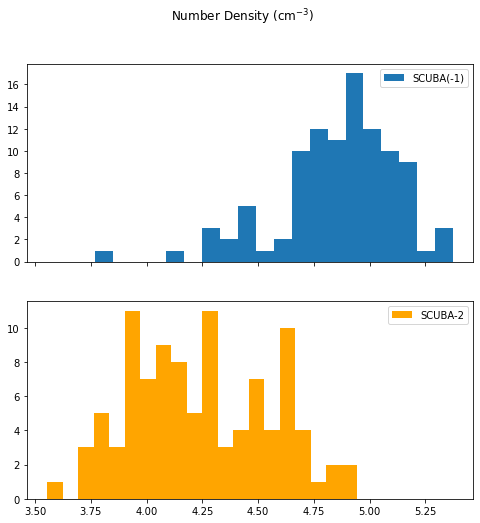

In [24]:
bins=20
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)
ax1.hist(np.log10(df_nwt_trimmed['Number_density']), bins=bins, label='SCUBA(-1)')
ax2.hist(np.log10(df_nwt_trimmed['SCUBA2 Number_density']), bins=bins, label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
fig.suptitle(r'Number Density (cm$^{-3}$)')
plt.show()

### Matched Concentration Values - B-North SCUBA1 and SCUBA2

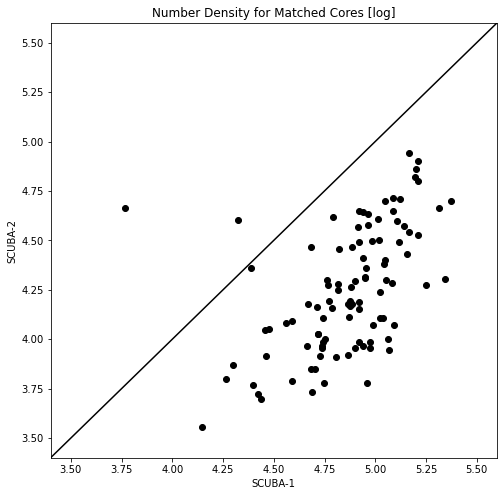

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(np.log10(df_nwt_trimmed['Number_density']), np.log10(df_nwt_trimmed['SCUBA2 Number_density']), c='k')
plt.axline((3.5,3.5), (5.5,5.5), color='k')
plt.title('Number Density for Matched Cores [log]')
plt.xlabel('SCUBA-1')
plt.ylabel('SCUBA-2')
plt.show()

### Peak Flux versus Number Density - SCUBA 1 Cores - Full Catalog (and B-North overlayed)

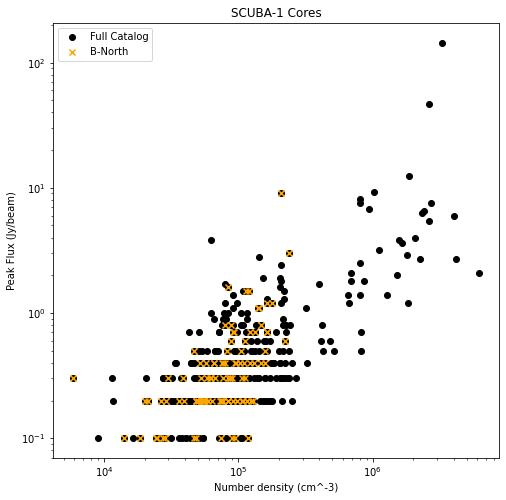

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(df_nwt['Number_density'], df_nwt['P850'], label='Full Catalog', c='k')
plt.scatter(df_nwt_trimmed['Number_density'], df_nwt_trimmed['P850'], label='B-North', c='orange', marker='x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number density (cm^-3)')
plt.ylabel('Peak Flux (Jy/beam)')
plt.title('SCUBA-1 Cores')
plt.legend()
plt.show()

### Peak Flux versus Number Density - SCUBA 2 Cores - Full Catalog only

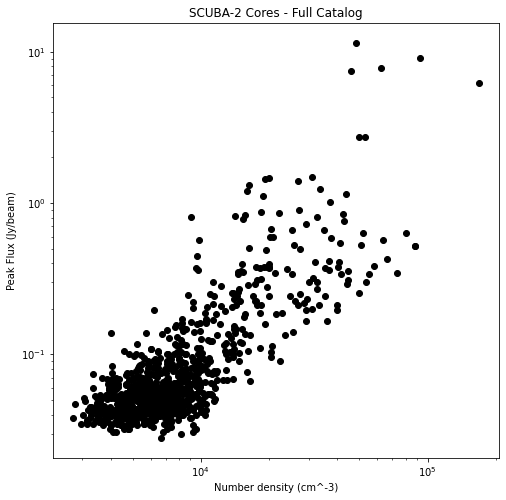

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(df_scuba2['Number_density'], df_scuba2['F850Pk'], label='Full Catalog', c='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number density (cm^-3)')
plt.ylabel('Peak Flux (Jy/beam)')
plt.title('SCUBA-2 Cores - Full Catalog')
plt.show()

### Effective Radius versus Number Density - SCUBA 1 Cores - Full Catalog (and B-North overlayed)

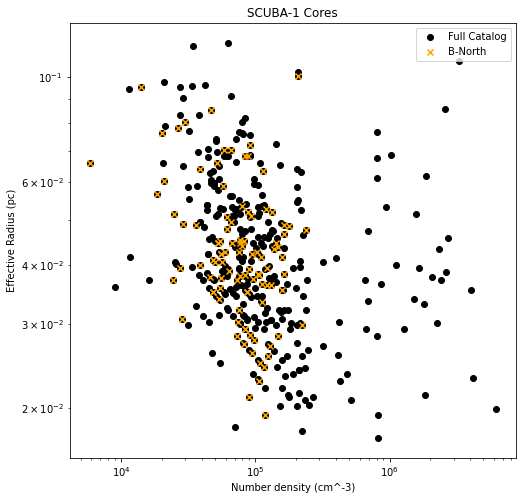

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(df_nwt['Number_density'], df_nwt['Reff_pc'], label='Full Catalog', c='black')
plt.scatter(df_nwt_trimmed['Number_density'], df_nwt_trimmed['Reff_pc'], label='B-North', c='orange', marker='x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number density (cm^-3)')
plt.ylabel('Effective Radius (pc)')
plt.title('SCUBA-1 Cores')
plt.legend()
plt.show()

Take a beamsize object, with a flux of three times the noise, what would it's density be in that case?

# Part 7 - Analysis of Lowest Density Objects

The goal of this portion is to see what type of object are the lowest density objects in the dataset. Are these types of objects very elongated, diffuse, generally large by the dataset standards? Where do these fall in terms of the general trends and distributions of the dataset?

Additionally, knowing the peak flux limit of the SCUBA-1 dataset, we can perform a somewhat rough calculation on the minimum number density of an object at the peak flux limit, fit into the beamsize. This will give us a rough idea on what value we should be comparing against for the values found in the dataset (and with comparison with SCUBA-2).

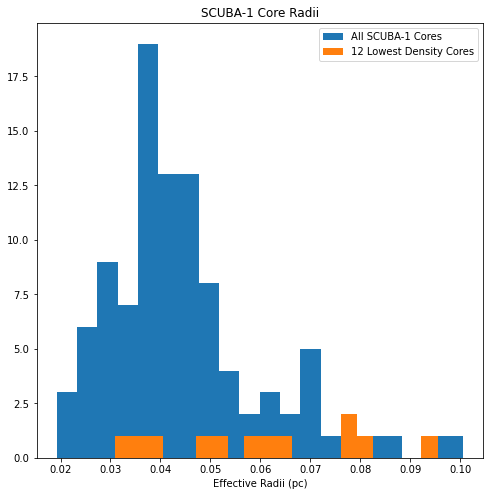

In [29]:
plt.figure(figsize=(8,8))
plt.hist(df_nwt_trimmed['Reff_pc'], bins=bins, label='All SCUBA-1 Cores')
plt.hist(df_nwt_trimmed[df_nwt_trimmed['Number_density'] < 10**4.5]['Reff_pc'], bins=bins, label='12 Lowest Density Cores')
plt.title('SCUBA-1 Core Radii')
plt.legend()
plt.xlabel('Effective Radii (pc)')
plt.show()

For these 12 objects, although uniform in distribution along the effective radii, taking into account that the distribution of radii for all cores is peaked at around 0.04, this does mean that 9 of the objects are larger than the mean, with many objects on the extended tail of this distribution.

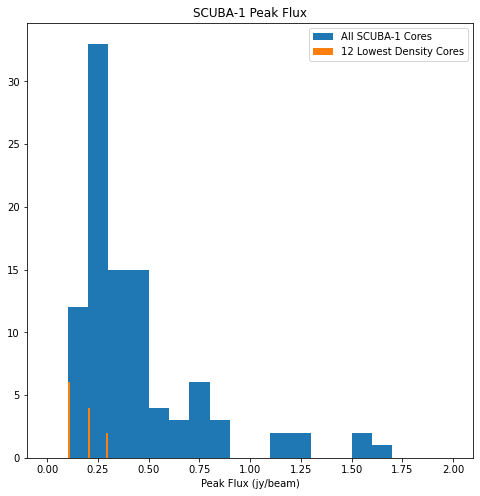

In [30]:
plt.figure(figsize=(8,8))
plt.hist(df_nwt_trimmed['P850'], range=(0,2), bins=20, label='All SCUBA-1 Cores')
plt.hist(df_nwt_trimmed[df_nwt_trimmed['Number_density'] < 10**4.5]['P850'], bins=bins, label='12 Lowest Density Cores')
plt.title('SCUBA-1 Peak Flux')
plt.legend()
plt.xlabel('Peak Flux (jy/beam)')
plt.show()

Alongside the effective radius, we do note that these 12 lowest density objects are indeed on the left hand side of this overall distribution of peak fluxes. Half of these 12 lowest density objects are found at the peak flux limit of this survey, at 0.1 Jy/beam.

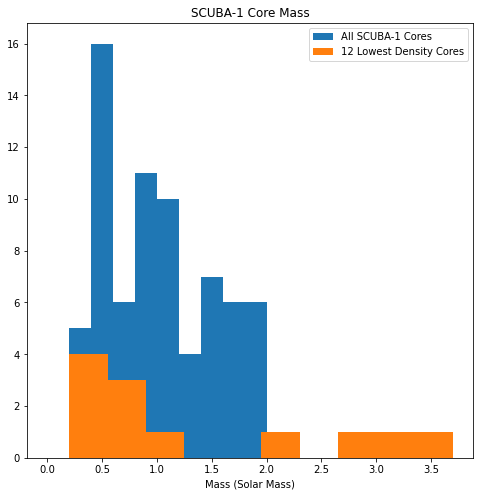

In [31]:
plt.figure(figsize=(8,8))
plt.hist(df_nwt_trimmed['Mass_msol'], range=(0,2), bins=10, label='All SCUBA-1 Cores')
plt.hist(df_nwt_trimmed[df_nwt_trimmed['Number_density'] < 10**4.5]['Mass_msol'], bins=10, label='12 Lowest Density Cores')
plt.title('SCUBA-1 Core Mass')
plt.legend()
plt.xlabel('Mass (Solar Mass)')
plt.show()

All the highest mass sources in the 12 lowest density objects, are themselves the highest effective radii entries.

## Computation of Minimum Number Density

Assuming that we were looking at an object at the sensitivity limit of the SCUBA-1 Peak Flux data (which seems to be 0.1 Jy/beam), at the given beamwidth of 14arcsec, this would translate into an object of the following Number Density:

In [32]:
# compute the mass of that object
print(f'Mass in Solar Masses: {scuba2mass(0.1, 419, 0.0125, 20):.3f}')
print(f'Associated Number Density: {numberdensity(scuba2mass(0.1, 419, 0.0125, 20), 14):.3e}')
print(f'Associated Number Density for smallest radii object (9.48arcsec): {numberdensity(scuba2mass(0.1, 419, 0.0125, 20), 9.48):.3e}')

Mass in Solar Masses: 0.145
Associated Number Density: 2.640e+04
Associated Number Density for smallest radii object (9.48arcsec): 8.503e+04


This would bring the computation of expected detections to:

In [34]:
print(f'Expected Detections > {(2/3) * 57 * np.sqrt(2.640e4/3.7656e7)}')

Expected Detections > 1.006163288644636
